# HESC differentiation causal analysis

In this tutorial, we demonstrate how to apply **CauTrigger** to a real single-cell RNA-seq dataset profiling the differentiation of human embryonic stem cells (hESCs) toward definitive endoderm.

Cells collected at **0 h** (state 0) and **96 h** (state 1) are treated as two distinct system states.

We will:
- preprocess data (highly variable genes),
- construct TF/TG inputs,
- train CauTrigger,
- examine top causal drivers,
- compare against a curated gold standard,
- visualize information flow between molecular layers.


## Import libraries and set working directory

In [1]:
import os
import sys
import warnings, logging
warnings.filterwarnings("ignore", module="matplotlib")
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from cautrigger.model import CauTrigger2L
from cautrigger.utils import set_seed

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'


BASE_DIR = os.path.abspath("..")  # go to 03_hesc/
case_path = BASE_DIR
data_path = os.path.join(case_path, 'data/')
output_path = os.path.join(case_path, 'output/')
os.makedirs(output_path, exist_ok=True)
data_path, output_path

('/mnt/e/Project_Research/CauTrigger_Project/CauTrigger-reproducibility/03_hesc/data/',
 '/mnt/e/Project_Research/CauTrigger_Project/CauTrigger-reproducibility/03_hesc/output/')

## Prepare data and run CauTrigger
We load the hESC expression matrix, select highly variable genes (HVG), 
split transcription factors (TFs) and downstream targets (TGs) based on TRRUST,
construct aligned TF/TG inputs for CauTrigger, and train a two-layer model.

In [2]:
# Load expression matrix
expData = pd.read_csv(os.path.join(data_path, 'hESC_ExpressionData.csv'), index_col=0).transpose()
adata = sc.AnnData(X=expData, dtype=np.float32)
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='cell_ranger')
hESC = adata[:, adata.var.highly_variable]

# TF prior (TRRUST v2)
Trrust = pd.read_table(os.path.join(data_path, 'trrust_rawdata.human.tsv'), header=None)
Trrust_TF = Trrust.iloc[:, 0].dropna().unique()
Trrust_nonTF = np.setdiff1d(Trrust.iloc[:, 1].dropna().unique(), Trrust_TF)

# Pseudotime → binary labels
hESC_pt = pd.read_csv(os.path.join(data_path, 'hESC_PseudoTime.csv'), index_col=0)
hESC_pt['cell_type_1'] = np.where(hESC_pt.index.str.contains('00h'), 0, np.where(hESC_pt.index.str.contains('96h'), 1, np.nan))
hESC.obs = hESC_pt

# Split TF/downstream genes by state
start_TF = hESC[(hESC.obs['cell_type_1'] == 0), np.intersect1d(hESC.var_names, Trrust_TF)]
end_TF = hESC[(hESC.obs['cell_type_1'] == 1), np.intersect1d(hESC.var_names, Trrust_TF)]
start_down = hESC[(hESC.obs['cell_type_1'] == 0), np.intersect1d(hESC.var_names, Trrust_nonTF)]
end_down = hESC[(hESC.obs['cell_type_1'] == 1), np.intersect1d(hESC.var_names, Trrust_nonTF)]

# Build AnnData for CauTrigger
adata = anndata.concat([start_TF.copy(), end_TF.copy()])
adata.obs['labels'] = np.repeat([0, 1], [start_TF.shape[0], end_TF.shape[0]])
adata.obsm['X_down'] = anndata.concat([start_down, end_down]).X.copy()

# Train CauTrigger
set_seed(42)
model = CauTrigger2L(
        adata,
        n_causal=2,
        n_latent=10,
    )
model.train(max_epochs=300, stage_training=True, im_factor=1)
# Extract ranked causal drivers
weight_df = model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=False)[0]
model_res = pd.DataFrame({'weight_value': weight_df['weight'], }).sort_values('weight_value', ascending=False)
model_res.head(10)


training: 100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:45<00:00,  6.54it/s]


,weight_value
SMAD2,0.027519
ZIC2,0.027348
EOMES,0.027201
OTX2,0.027046
APC,0.027044
GATA6,0.026952
ZIC3,0.026899
NANOG,0.026859
PRDM1,0.026833
WWP1,0.026580


## Venn overlap with ground truths

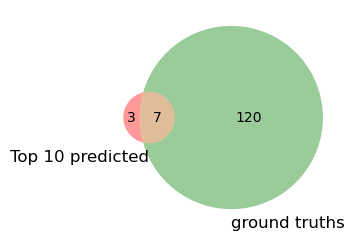

In [3]:
def load_ground_truth(data_path):
    hESC_ground_truth = {}
    Trrust_human = pd.read_table(os.path.join(data_path, 'trrust_rawdata.human.tsv'), header=None)
    Trrust_human_TF = Trrust_human.iloc[:, 0].dropna().unique()
    hESC_files = [
        ('cell_fate_commitment', 'GO_CELL_FATE_COMMITMENT_my.txt'),
        ('stem_cell_population_maintenance', 'GO_STEM_CELL_POPULATION_MAINTENANCE_my.txt'),
        ('endoderm_development', 'GO_ENDODERM_DEVELOPMENT_my.txt')
    ]
    for name, file in hESC_files:
        df = pd.read_csv(os.path.join(data_path, file))
        hESC_ground_truth[name] = set(np.intersect1d(df.iloc[:, 0], Trrust_human_TF))
    cell2011_genes = set(pd.read_csv(os.path.join(data_path, 'ESC_Cell2011.csv'), encoding='latin1')['TFs'])
    reproduction2008_genes = set(pd.read_csv(os.path.join(data_path, 'ESC_Reproduction2008.csv'))['TFs'])
    literature_curated = cell2011_genes.union(reproduction2008_genes)
    hESC_ground_truth['literature_curated'] = literature_curated
    hESC_ground_truth['all'] = set.union(*hESC_ground_truth.values())
    return hESC_ground_truth
    
from matplotlib_venn import venn2

gt = load_ground_truth(data_path)['all']  # reuse previous function
pred = set(model_res.head(10).index)

plt.figure(figsize=(3,3))
venn2([pred, gt], set_labels=('Top 10 predicted', 'ground truths'))
plt.show()


## Visualize causal information flow

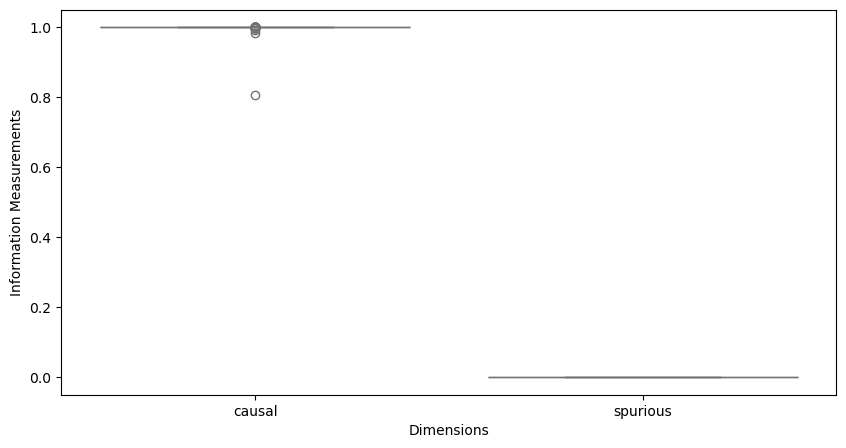

In [4]:
flow = model.compute_information_flow(zero_floor=True, save_fig=False, skip_single_info=True)